## A. Sample person and cyclist annotations from the annotations
- COCO 2017 train/val dataset (80 classes, 123,287 images, 886,284 instances).
- Read annotations/instances_{train,val}2017.json
- Filter images with [person, bicycle]
- Add a new class label, outer-bounding-box called `cyclist` if `person` & `bicycle` have IoU>20%
- Dump the new annotations to a new file suffixed `cyclist`


In [15]:
import os
import numpy as np
import pandas as pd

In [16]:

import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [17]:
COCO_DATA_HOME = "/media/rahul/HIT-GRAID/data/coco"

In [18]:
# List the files in the folder
! ls -lh $COCO_DATA_HOME/annotations/instances*

-rwxrwxrwx 1 rahul rahul 513K Jul 10  2019 /media/rahul/HIT-GRAID/data/coco/annotations/instances_minival2014_100.json
-rwxrwxrwx 1 rahul rahul 449M Sep  1  2017 /media/rahul/HIT-GRAID/data/coco/annotations/instances_train2017.json
-rwxrwxrwx 1 rahul rahul 1.2M Aug  7  2020 /media/rahul/HIT-GRAID/data/coco/annotations/instances_val2017_100.json
-rwxrwxrwx 1 rahul rahul  73M Jul 23  2021 /media/rahul/HIT-GRAID/data/coco/annotations/instances_val2017.json


In [36]:
from pycocotools.coco import COCO
from torch.utils.data.dataset import Dataset

class COCODatasetCustom(Dataset):
    """
    COCO dataset class.
    """

    def __init__(
        self,
        data_dir=None,
        json_file="instances_train2017.json",
        name="train2017",
        img_size=(416, 416),
        preproc=None,
        cache=False,
    ):
        """
        COCO dataset initialization. Annotation data are read into memory by COCO API.
        Args:
            data_dir (str): dataset root directory
            json_file (str): COCO json file name
            name (str): COCO data name (e.g. 'train2017' or 'val2017')
            img_size (int): target image size after pre-processing
            preproc: data augmentation strategy
        """
        #super().__init__(img_size)
        self.data_dir = data_dir
        self.json_file = json_file

        self.coco = COCO(os.path.join(self.data_dir, "annotations", self.json_file))
        self.ids = self.coco.getImgIds()
        self.class_ids = sorted(self.coco.getCatIds())
        self.cats = self.coco.loadCats(self.coco.getCatIds())
        self._classes = tuple([c["name"] for c in self.cats])
        self.imgs = None
        self.name = name
        self.img_size = img_size
        self.preproc = preproc
        self.annotations = self._load_coco_annotations()


    def __len__(self):
        return len(self.ids)

    def __del__(self):
        del self.imgs

    def _load_coco_annotations(self):
        return [self.load_anno_from_ids(_ids) for _ids in self.ids]

    def load_anno_from_ids(self, id_):
        im_ann = self.coco.loadImgs(id_)[0]
        width = im_ann["width"]
        height = im_ann["height"]
        anno_ids = self.coco.getAnnIds(imgIds=[int(id_)], iscrowd=False)
        annotations = self.coco.loadAnns(anno_ids)
        objs = []
        for obj in annotations:
            x1 = np.max((0, obj["bbox"][0]))
            y1 = np.max((0, obj["bbox"][1]))
            x2 = np.min((width, x1 + np.max((0, obj["bbox"][2]))))
            y2 = np.min((height, y1 + np.max((0, obj["bbox"][3]))))
            if obj["area"] > 0 and x2 >= x1 and y2 >= y1:
                obj["clean_bbox"] = [x1, y1, x2, y2]
                objs.append(obj)

        num_objs = len(objs)

        res = np.zeros((num_objs, 5))

        for ix, obj in enumerate(objs):
            cls = self.class_ids.index(obj["category_id"])
            res[ix, 0:4] = obj["clean_bbox"]
            res[ix, 4] = cls

        r = min(self.img_size[0] / height, self.img_size[1] / width)
        res[:, :4] *= r

        img_info = (height, width)
        resized_info = (int(height * r), int(width * r))

        file_name = (
            im_ann["file_name"]
            if "file_name" in im_ann
            else "{:012}".format(id_) + ".jpg"
        )

        return (res, img_info, resized_info, file_name)

    def load_anno(self, index):
        return self.annotations[index][0]

    def load_resized_img(self, index):
        img = self.load_image(index)
        r = min(self.img_size[0] / img.shape[0], self.img_size[1] / img.shape[1])
        resized_img = cv2.resize(
            img,
            (int(img.shape[1] * r), int(img.shape[0] * r)),
            interpolation=cv2.INTER_LINEAR,
        ).astype(np.uint8)
        return resized_img

    def load_image(self, index):
        file_name = self.annotations[index][3]

        img_file = os.path.join(self.data_dir, self.name, file_name)

        img = cv2.imread(img_file)
        assert img is not None, f"file named {img_file} not found"

        return img

In [37]:
def read_annotations(ann_type, allowed_list=["person", "bicycle"]):
    ann_file = "instances_{}.json".format(ann_type)
    print("Read Annotation from -> {}".format(ann_file))
    coco_custom = COCODatasetCustom(data_dir=COCO_DATA_HOME, json_file=ann_file, name=ann_type)   
    return coco_custom

In [38]:
anns_dict = {}
for ann in ["train2017", "val2017"]:
    anns_dict[ann] = read_annotations(ann)

Read Annotation from -> instances_train2017.json
loading annotations into memory...
Done (t=8.65s)
creating index...
index created!
Read Annotation from -> instances_val2017.json
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [39]:
val2017 = anns_dict["val2017"]

In [40]:
print("Cats: ", val2017.cats)

Cats:  [{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'superc

In [41]:
print("Classes: ",val2017._classes)

Classes:  ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush')


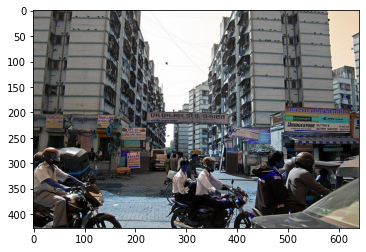

In [44]:
plt. imshow(val2017.load_image(10))